In [1]:
import numpy as np
import xarray as xr
import sys
sys.path.insert(1, '/home/a/a270230/LKF/lkf_tools/lkf_tools/')
from dataset import *
sys.path.insert(1, '/home/a/a270230/LKF/lkf_detection/functions/')
from statistics_functions import *
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
plt.rcParams.update({'font.size':16})
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import cmocean

In [2]:
res = '1km'

path = '/work/bk1377/a270230/'
path_nc   = path + f'interpolated_fesom_output/'
path_ds   = path + f'datasets/{res}/'
path_stat = path + 'statistics/'
path_imgs = path + 'imgs/'

In [3]:
year = 2015

In [4]:
file = xr.open_dataset(path_nc + f'{year}_{res}_monthly.nc')
line = ( (((file.ULON > -120) & (file.ULON < 100)) & (file.ULAT >= 79.9) & (file.ULAT <= 80))
        | (((file.ULON > -120.5) & (file.ULON <= -120)) & (file.ULAT >= 70) & (file.ULAT < 80))
        | (((file.ULON < 100.5) & (file.ULON >= 100)) & (file.ULAT >= 70) & (file.ULAT < 80))
        | ((file.ULON <= -120) & (file.ULAT >= 69.9) & (file.ULAT <= 70)  )
        | ((file.ULON >= 100) & (file.ULAT >= 69.9) & (file.ULAT <= 70))
       )
line = np.where(line==1,1,np.nan)

lkf_data = np.load(path_ds + f'ds_{year}_{res}.npy', allow_pickle=True)[0]

if res == '1km': z = 70*4
if res == '4km': z = 70
# arctic basin
a = max([0,lkf_data.index_y[0][0]-1])
b = lkf_data.index_y[0][-1]+2
c = max([0,lkf_data.index_x[0][0]-1])
d = lkf_data.index_x[0][-1]+2 - z
e = lkf_data.red_fac

lon = lkf_data.lon[a:b:e,c:d:e]
lat = lkf_data.lat[a:b:e,c:d:e]

In [5]:
def get_date(i, monthly=False):
    if monthly:
        startdays = np.append(0,xticks[:-1])
        day = startdays[i]+1
    else:
        day = i+1
    day = str(day)
    day.rjust(3 + len(day), '0')
    date = datetime.strptime(f'{year}-{day}', "%Y-%j").strftime("%m-%d-%Y")
    return date

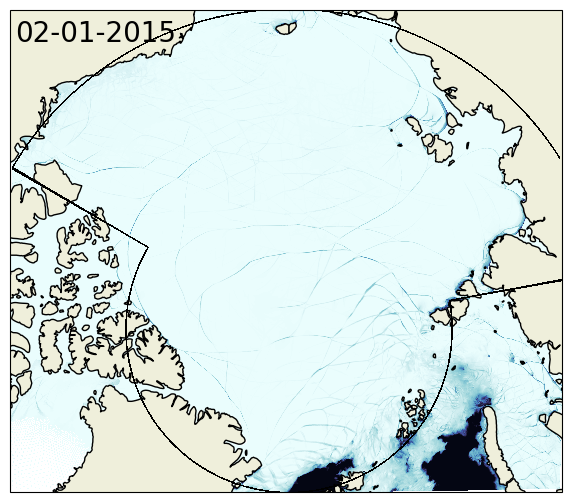

In [6]:
i = 1
monthly = True

fig = plt.figure(figsize=[6, 6])
ax = plt.subplot(111, projection=ccrs.Orthographic(0, 90))

ax.add_feature(cfeature.LAND, zorder=2, edgecolor='black')
ax.pcolormesh(lon, lat, line[a:b,c:d], transform = ccrs.PlateCarree(),
              cmap = 'Greys', vmin=-1, vmax=0, zorder=3)

im = ax.pcolormesh(lon, lat, file.A.isel(time=i)[a:b,c:d], transform=ccrs.PlateCarree(),
                   cmap = cmocean.cm.ice, vmin=0, vmax=1)

ax.text(0.01, 0.98, f'{get_date(i, monthly)}', transform=ax.transAxes, fontsize=20, verticalalignment='top')
#ax.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
#plt.colorbar(im, label='sea ice concentration', fraction=0.1, pad=0.02, orientation='horizontal')
fig.tight_layout()
#plt.savefig(path_imgs + 'arctic_basin_region.png', dpi=100, bbox_inches='tight')

In [7]:
LKFs = np.load(path_stat + f'LKFs_{res}.npy', allow_pickle=True)[0]

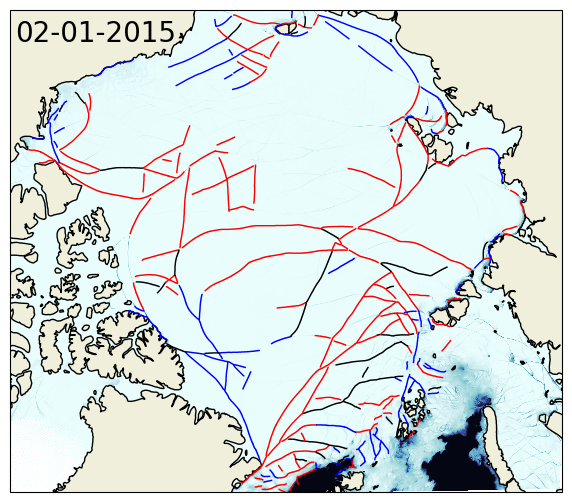

In [8]:
i = 1
monthly = True

fig = plt.figure(figsize=[6, 6])
ax = plt.subplot(111, projection=ccrs.Orthographic(0, 90))

ax.add_feature(cfeature.LAND, zorder=2, edgecolor='black')

im = ax.pcolormesh(lon, lat, file.A.isel(time=i)[a:b,c:d], transform=ccrs.PlateCarree(),
                   cmap = cmocean.cm.ice, vmin=0, vmax=1)

day = i + 1
if monthly: day = np.append(0,xticks[:-1])[i]+1
lkfs = np.load(lkf_data.lkfpath.joinpath('lkf_%s_%03i.npy' %(lkf_data.netcdf_file.split('/')[-1].split('.')[0],(day))),allow_pickle=True)

for ind_lkf, lkf in enumerate(lkfs):
    if np.min(lkf[:,2])<-150 and np.max(lkf[:,2]>150):
        lkf[lkf[:,2]<0,2]+=360
        
    lkf_type = LKFs[f'y{year}'][f'd{day-1}']['lead or ridge'][ind_lkf]
    if lkf_type==1: color='b'
    if lkf_type==2: color='r'
    if lkf_type==3: color='k'
    
    ax.plot(lkf[:,2], lkf[:,3], transform=ccrs.PlateCarree(), linewidth=1, color=color)

blue_line = mlines.Line2D([], [], color='b', label='Lead', linewidth=2)
red_line = mlines.Line2D([], [], color='r', label='Ridge', linewidth=2)
black_line = mlines.Line2D([], [], color='k', label='Not Quantifiable', linewidth=2)
#plt.legend(handles=[blue_line, red_line, black_line], loc='upper right', bbox_to_anchor=(1.5, 1))

ax.text(0.01, 0.98, f'{get_date(i, monthly)}', transform=ax.transAxes, fontsize=20, verticalalignment='top')
fig.tight_layout()

## Comparing different resolutions

In [9]:
def plot(year, var, vmax, label, plot_lkfs):
    resolutions = ['1km', '4km']
    titles = ['1 km', '4.5 km']
    fig = plt.figure(figsize=[10, 6])
    axs = [fig.add_subplot(1,2,col, projection=ccrs.Orthographic(0, 90)) for col in [1,2]]

    for ax, res, title in zip(axs, resolutions, titles):

        lkf_data = np.load(path + f'datasets/{res}/ds_{year}_{res}.npy', allow_pickle=True)[0]
        file = xr.open_dataset(path_nc + f'{year}_{res}_monthly.nc')

        # scale the arctic basin indizes with the resolution
        res_fac = int(res[0])
        a_ = int(a/res_fac)
        b_ = int(b/res_fac)
        c_ = int(c/res_fac)
        d_ = int(d/res_fac)

        lon = lkf_data.lon[a_:b_,c_:d_]
        lat = lkf_data.lat[a_:b_,c_:d_]

        ax.add_feature(cfeature.LAND, zorder=2, edgecolor='black')

        im = ax.pcolormesh(lon, lat, file[var].isel(time=i)[a_:b_,c_:d_], transform=ccrs.PlateCarree(),
                           cmap = cmocean.cm.ice, vmin=0, vmax=vmax)
        ax.set_title(f'horizonal resolution = {title}')

        if plot_lkfs:
            day = i + 1
            if monthly: day = np.append(0,xticks[:-1])[i]+1
            lkfs = np.load(lkf_data.lkfpath.joinpath('lkf_%s_%03i.npy' %(lkf_data.netcdf_file.split('/')[-1].split('.')[0],(day))),allow_pickle=True)


            for ind_lkf, lkf in enumerate(lkfs):
                if np.min(lkf[:,2])<-150 and np.max(lkf[:,2]>150):
                    lkf[lkf[:,2]<0,2]+=360

                lkf_type = LKFs[f'y{year}'][f'd{day-1}']['lead or ridge'][ind_lkf]
                if lkf_type==1: color='b'
                if lkf_type==2: color='r'
                if lkf_type==3: color='k'

                ax.plot(lkf[:,2], lkf[:,3], transform=ccrs.PlateCarree(), linewidth=1, color=color)


    fig.tight_layout()
    p0 = axs[0].get_position().get_points().flatten()
    p1 = axs[1].get_position().get_points().flatten()
    ax_cbar = fig.add_axes([p0[0], 0.1, p1[2]-p0[0], 0.05])
    plt.colorbar(im, label=label, cax=ax_cbar, orientation='horizontal')

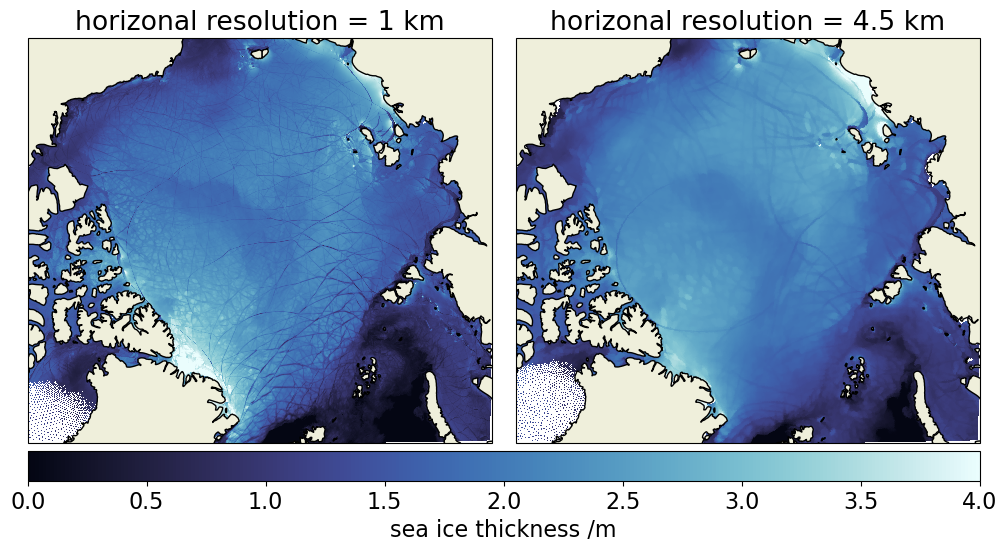

In [10]:
plot(2015, 'H', 4, 'sea ice thickness /m', False)